<div style="display: flex; align-items: center; justify-content: left; padding: 0px;">
    <div class="logo-container" style="flex:0.13;height:100%;">
        <img src="https://raw.githubusercontent.com/andikaaa18/Tripleten_datascience_project/main/Assets/logo_tripleten.png" alt="Logo" style="max-height: 155px; width: auto; filter:invert(0%);">
    </div>
    <div class="title-container" style="flex:0.85;height:75%;text-align: left">
        <div style="margin: 0px 0px 0px 0px; font-size: 40px; font-family:Trebuchet MS; font-weight:bold; line-height:40px;">Tripleten Indonesia Project</div>
        <div style="margin: 0px 0px 0px 0px; font-size: 30px; font-family:Trebuchet MS;">&mdash; Sprint 15 : Computer Vision</div>
    </div>
</div>

<hr style="width:95%;height:2px;background-color:black;" align="left">

<div style="font-family:Trebuchet MS; font-weight:bold; font-size:35px; text-align:left; line-height:40px">
Age Estimation Using Modified ResNet50V2 for Enhanced Supermarket Services
</div>
<div style="font-family:Trebuchet MS; font-weight:regular; font-size:20px; text-align:left; ">
&mdash; Memodifikasi dan <i>finetuning</i> model ResNet untuk kebutuhan tugas regresi.
</div>

# **A. Pendahuluan**

## 1) Deskripsi Proyek

<h3 style="font-family:Trebuchet MS; font-weight:bold; padding-bottom:0px">Sebuah waralaba supermarket ingin menerapkan sistem visi komputer untuk meningkatkan kualitas layanan.</h3>

<div style="margin-left:2%; width:95%; text-align:justify">

Saat ini kita bekerja untuk sebuah waralaba supermarket yang bernama **Good Seed**. **Good Seed** ingin meningkatkan kualitas layanan agar usahanya berkembang dengan cara menawarkan produk yang menarik dan sesuai dengan usia pelanggan. Oleh karena itu, **Good Seed** perlu menganalis pembelian produk pada setiap kelompok umur, membuat sistem yang dapat memberikan rekomendasi kepada pelanggan untuk kelompok umur tertentu, dan membuat sistem yang dapat mengawasi pegawai yang menjual produk dengan batasan usia. 

Oleh karena itu sebelum membuat sistem tersebut, **Good Seed** akan membuat sistem pemindai di area kasir, dimana sistem tersebut akan mampu memprediksi usia pelanggan yang dipindai oleh sistem. Tugas kita disini, yaitu membuat suatu model yang dapat memprediksi usia pembeli berdasarkan foto pembeli hasil pemindaian.
</div>

## 2) Tujuan dan Alur Proses

<h3 style="font-family:Trebuchet MS; font-weight:bold">Tujuan</h3>
<div style="margin-left:2%; width:95%; text-align:justify">

Berikut di bawah ini merupakan tujuan yang ingin dicapai pada proyek ini:
1. Mampu membuat model visi komputer yang dapat memprediksi usia berdasarkan foto yang diberikan. Persyaratan kualitas model prediktif adalah skor MAE &le; 8 tahun.
</div>

<h3 style="font-family:Trebuchet MS; font-weight:bold">Alur Proyek</h3>
<div style="margin-left:2%; width:95%;text-align:justify">

Adapun proses yang akan dilakukan dalam proses analis untuk proyek ini terdiri dari beberapa langkah utama, yaitu:
1. **Ikhtisar Data.** <div> Pada bagian ini, data yang telah diimpor akan dipahami setiap parameter data serta sejumlah catatan dokumentasi terkait dataset.</div>            
2. **Analisa Data Eksploratif.** <div> Pada bagian ini data akan diamati dan dianalisis untuk memperoleh *insight* dari sebuah data.</div>
3. **Membangun Model *Machine-learning*.** <div> Pada bagian ini akan dilakukan proses *feature engineering*, membangun arsitektur model, melatih model dan evaluasi model.
</div>

</div>

# **B. Memuat Data**

* Memuat sejumlah *library* dan data yang dibutuhkan.

In [1]:
# library for data processing
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# library for data visualization
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

# library for building models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# library model evaluation

# other
import os
import tempfile
import re
import ast

pd.options.mode.chained_assignment = None

In [2]:
# setting grafik untuk visualisasi data
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [3]:
# memuat dataset
try:
    data = pd.read_csv("../datasets/faces/labels.csv")
    
except:
    data = pd.read_csv("/datasets/faces/labels.csv")

# **C. Ikhtisar Data**

Berikut di bawah ini ditampilkan 10 baris data pada dataset yang akan dianalisis.

In [4]:
# menampilkan informasi data dan 10 data pertama
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39

Pada proyek ini, terdapat sebanyak 7591 photo yang akan digunakan. Data photo dan usia disimpan pada folder `/datasets/faces/` dimana di dalamnya terdapat folder `/datasets/faces/final_files/` yang berisi serangkaian photo-photo. Adapun informasi usia untuk masing-masing photo disimpan di dalam file `/datasets/faces/labels.csv`, dimana di dalamnya terdapat kolom `'file_name'` yang merupakan nama file photo dan kolom `'real_age'` yang merupakan usia seseorang di dalam photo tersebut. 

# **D. Analisa Data Eksploratif (EDA)**

Berikut di bawah ini merupakan 30 buah photo yang diambil secara acak dari dalam dataset.

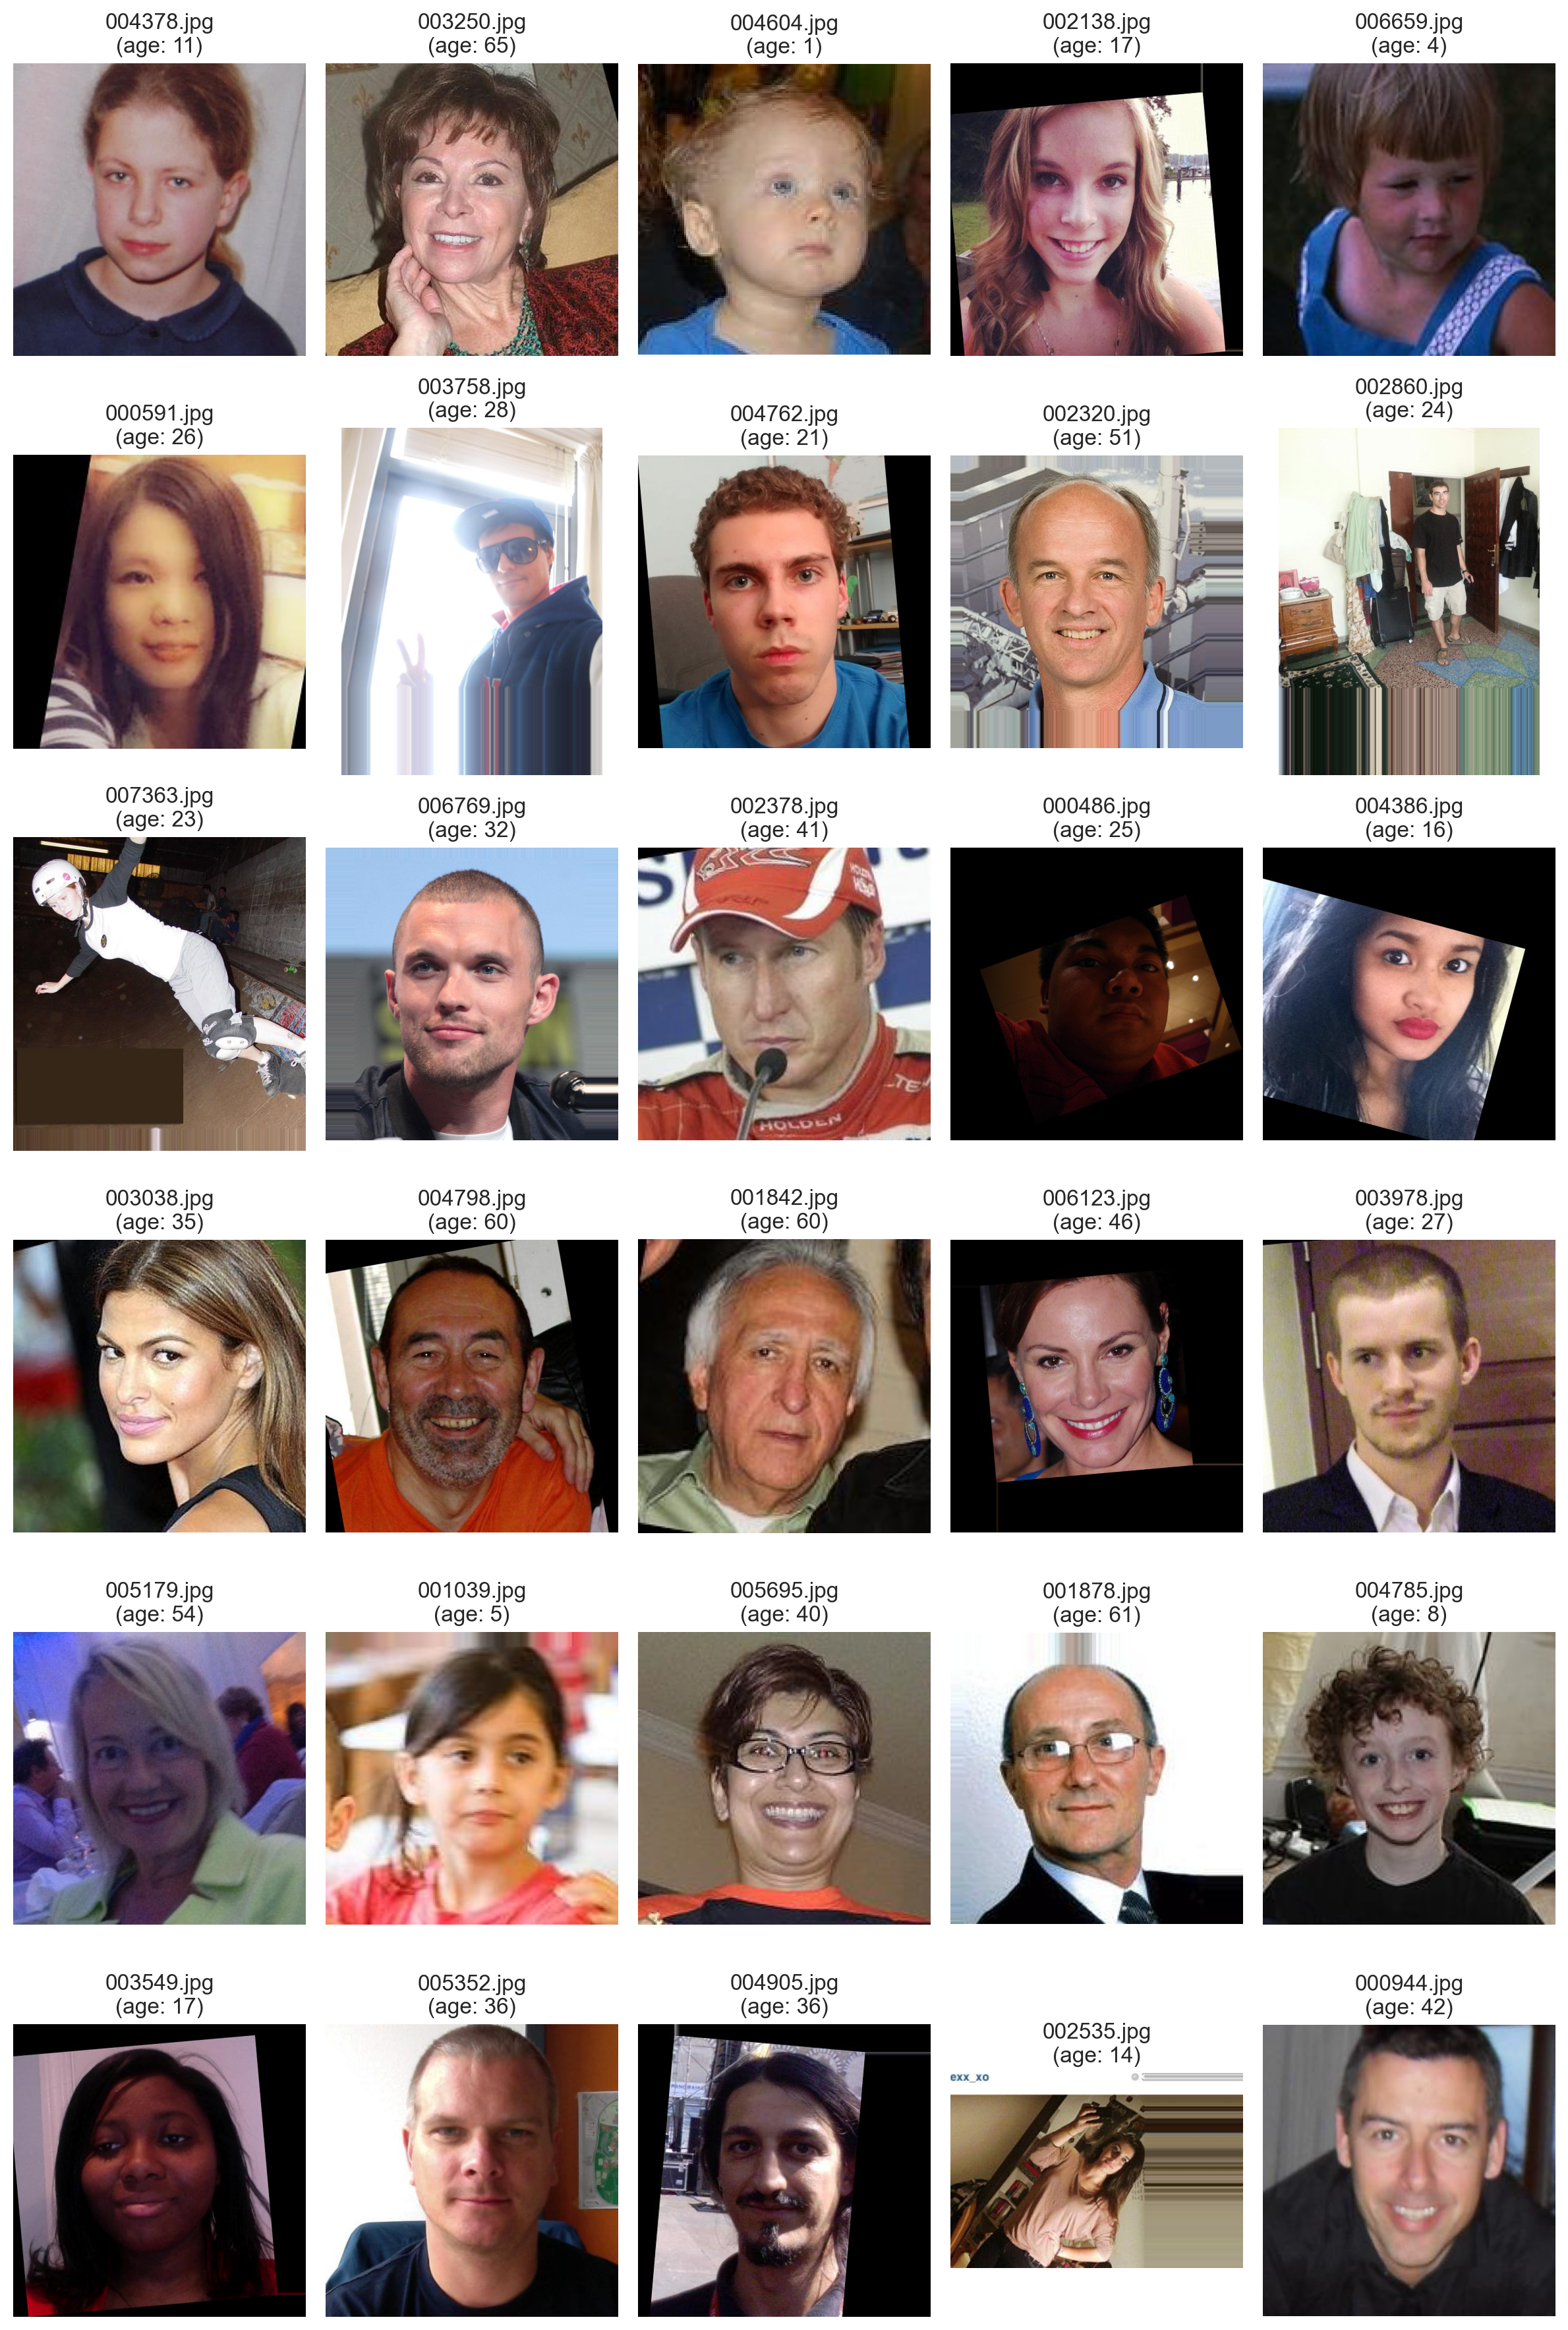

In [5]:
def read_image(file_name):
    image = Image.open("../datasets/faces/final_files/" + file_name)
    return np.array(image)

n = 30
random_n = data.sample(n, random_state=101010)

plt.figure(figsize=(12, 3*n//5))
for i in range(n):
    plt.subplot(n//5, 5, i+1)
    plt.imshow(read_image(random_n['file_name'].values[i]))
    plt.axis('off')
    plt.title(random_n['file_name'].values[i] + f"\n(age: {random_n['real_age'].values[i]})")
plt.tight_layout()

<h3 style="font-weight:bold; font-family:Trebuchet MS">Findings</h3>
<div style="margin-left:1%; margin-top:1%; width:97%; text-align:justify">

* Ukuran photo di dalam dataset bervariasi.
* Orientasi photo beragam, ada yang portrait dan ada pula yang landscape. Terdapat pula sejumlah photo yang tidak dalam posisi tegak, tetapi sedikit miring. Ditemukan pula sejumlah photo yang sudah augmentasi berupa ***shifting***.
* Terdapat gambar dengan pencahayaan yang baik, dan ada pula dengan pencahayaan yang kurang.
* Photo di dalam dataset berisi orang-orang dengan usia yang beragam

</div>

Berikut di bawah ini, kita akan melihat ukuran minimum dan maksimum photo di dalam dataset.

In [6]:
# melihat piksel minimum dan maksimum
min_x, max_x, min_y, max_y = 1e7, 0, 1e7, 0

for img in data['file_name']:
    size = read_image(img).shape
    max_x = size[1] if size[1]>max_x else max_x
    min_x = size[1] if size[1]<min_x else min_x
    max_y = size[0] if size[0]>max_y else max_y
    min_y = size[0] if size[0]<min_y else min_y
        
print(f"min_x: {min_x}px   max_x: {max_x}px   min_y: {min_y}px   max_y: {max_y}px")

min_x: 47px   max_x: 4466px   min_y: 47px   max_y: 4466px


<h3 style="font-weight:bold; font-family:Trebuchet MS">Findings & Insights</h3>
<div style="margin-left:1%; margin-top:1%; width:97%; text-align:justify">

* Rentang lebar photo di dalam dataset, yaitu 47 px hingga 4466 px.
* Rentang tinggi photo di dalam dataset, yaitu 47 px hingga 4466 px.
* Pada proyek ini, kita akan menggunakan photo dengan ukuran 150x150 px sebagai input model, sehingga gambar yang ada harus di-*resize*.

</div>

Berikut di bawah ini akan ditampilkan distribusi usia di dalam dataset.

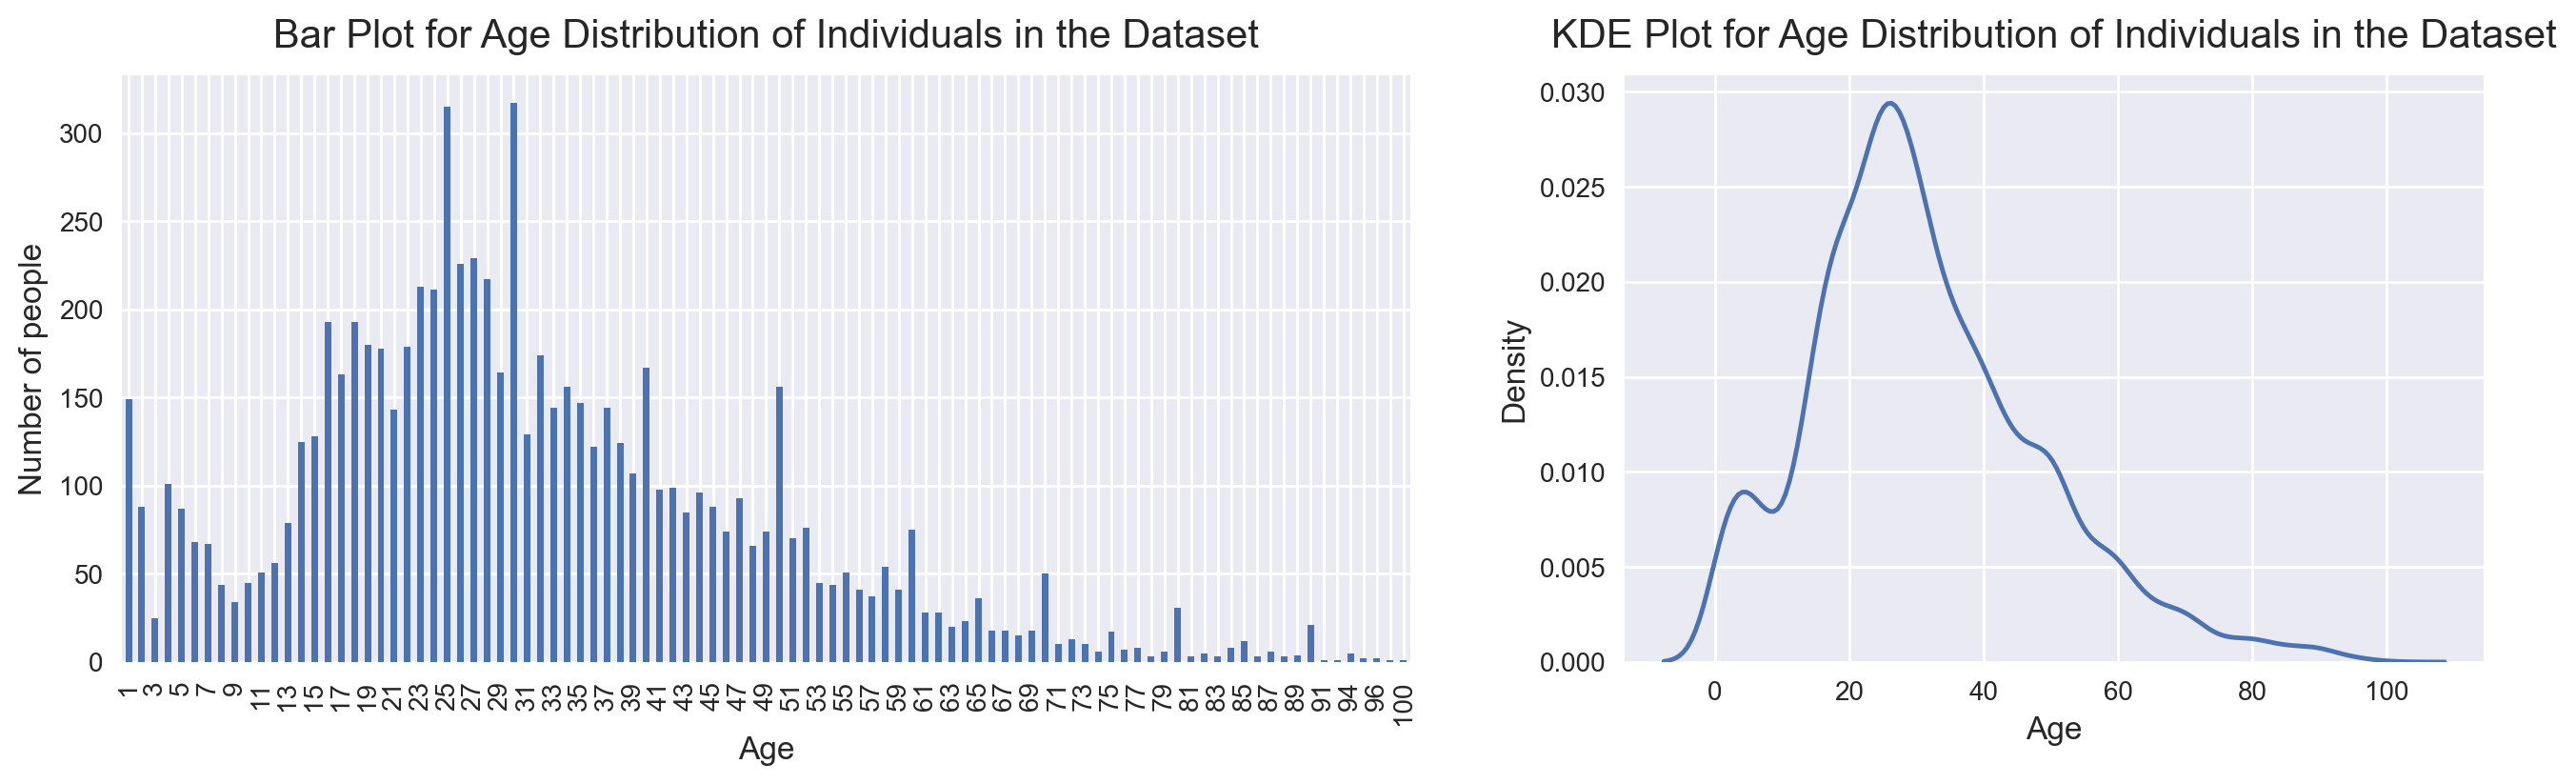

count       mean       std  min   25%   50%   75%    max
real_age  7591.0  31.201159  17.14506  1.0  20.0  29.0  41.0  100.0

In [7]:
# counting data age
age_count = data.groupby('real_age')['file_name'].count()

# grafik
fig, ax = plt.subplots(ncols=2, figsize=(16, 4), width_ratios=[3, 2])
age_count.plot(kind='bar', ax=ax[0])
sns.kdeplot(data['real_age'], ax=ax[1])

# mengatur xtick labels
xtick_labels = ax[0].get_xticklabels()
plt.setp(xtick_labels, visible=False)
plt.setp(xtick_labels[::2], visible=True)

# atribut grafik
ax[0].set_title("Bar Plot for Age Distribution of Individuals in the Dataset", size=15, y=1.02)
ax[0].set_ylabel("Number of people", size=12)
ax[0].set_xlabel("Age", size=12)
ax[1].set_title("KDE Plot for Age Distribution of Individuals in the Dataset", size=15, y=1.02)
ax[1].set_ylabel("Density", size=12)
ax[1].set_xlabel("Age", size=12)

plt.show()

# dekskripsi data usia
data[['real_age']].describe().T

<h3 style="font-weight:bold; font-family:Trebuchet MS">Findings & Insights</h3>
<div style="margin-left:1%; margin-top:1%; width:97%; text-align:justify">

* Median usia orang di dalam dataset, yaitu 29 tahun.
* Grafik memiliki distribusi *right-skew*. Hal ini menunjukkan lebih banyak orang berusia muda di dalam dataset.
* Dari grafik terlihat bahwa terdapat sebuah *sub-mode* pada rentang usia 1-5 tahun. Hal ini menunjukkan bahwa photo di dalam dataset di dominasi oleh orang dewasa muda (&pm;30 tahun) dan anak-anak pada urutan kedua (&pm;5 tahun).
* Berdasarkan metode IQR, maka data yang tergolong bukan *outliers*, yaitu mereka yang berusia 0 - 72,5 tahun.

</div>

# **E. Membangun Model ML**

## 1) Feature Engineering

Untuk meningkatkan kualitas model, kita perlu membuang data *outliers*. Berdasarkan metode IQR, data yang tergolong *outliers* adalah mereka yang berusia di atas 72,5 tahun.

In [8]:
# mengeluarkan outliers
q3 = data['real_age'].quantile(0.75)
q1 = data['real_age'].quantile(0.25)
iqr = q3 - q1
lower_bound = np.ceil(np.max([0, q1-1.5*iqr]))
upper_bound = np.ceil(q3+1.5*iqr)
filter_data = data.query("@lower_bound<=real_age<=@upper_bound")

Berikut di bawah ini kita akan melakukan *data split* untuk memisahkan antara *training set*, *validation set* dan *test set*. Proporsi yang digunakan yaitu 70% *training set*, 15% *validation set* dan 15% *test set*.

In [9]:
# data split
train_data, val_data = train_test_split(filter_data, test_size=0.3, random_state=101010)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=101010)

# ukuran dataset
print(f"train_data.shape: {train_data.shape}")
print(f"val_data.shape  : {val_data.shape}")
print(f"test_data.shape : {test_data.shape}")

train_data.shape: (5202, 2)
val_data.shape  : (1115, 2)
test_data.shape : (1115, 2)


Berikut di bawah ini merupakan distribusi usia pada masing-masing dataset untuk memeriksa apakah ketiga dataset memiliki distribusi yang serupa setelah *data split*.

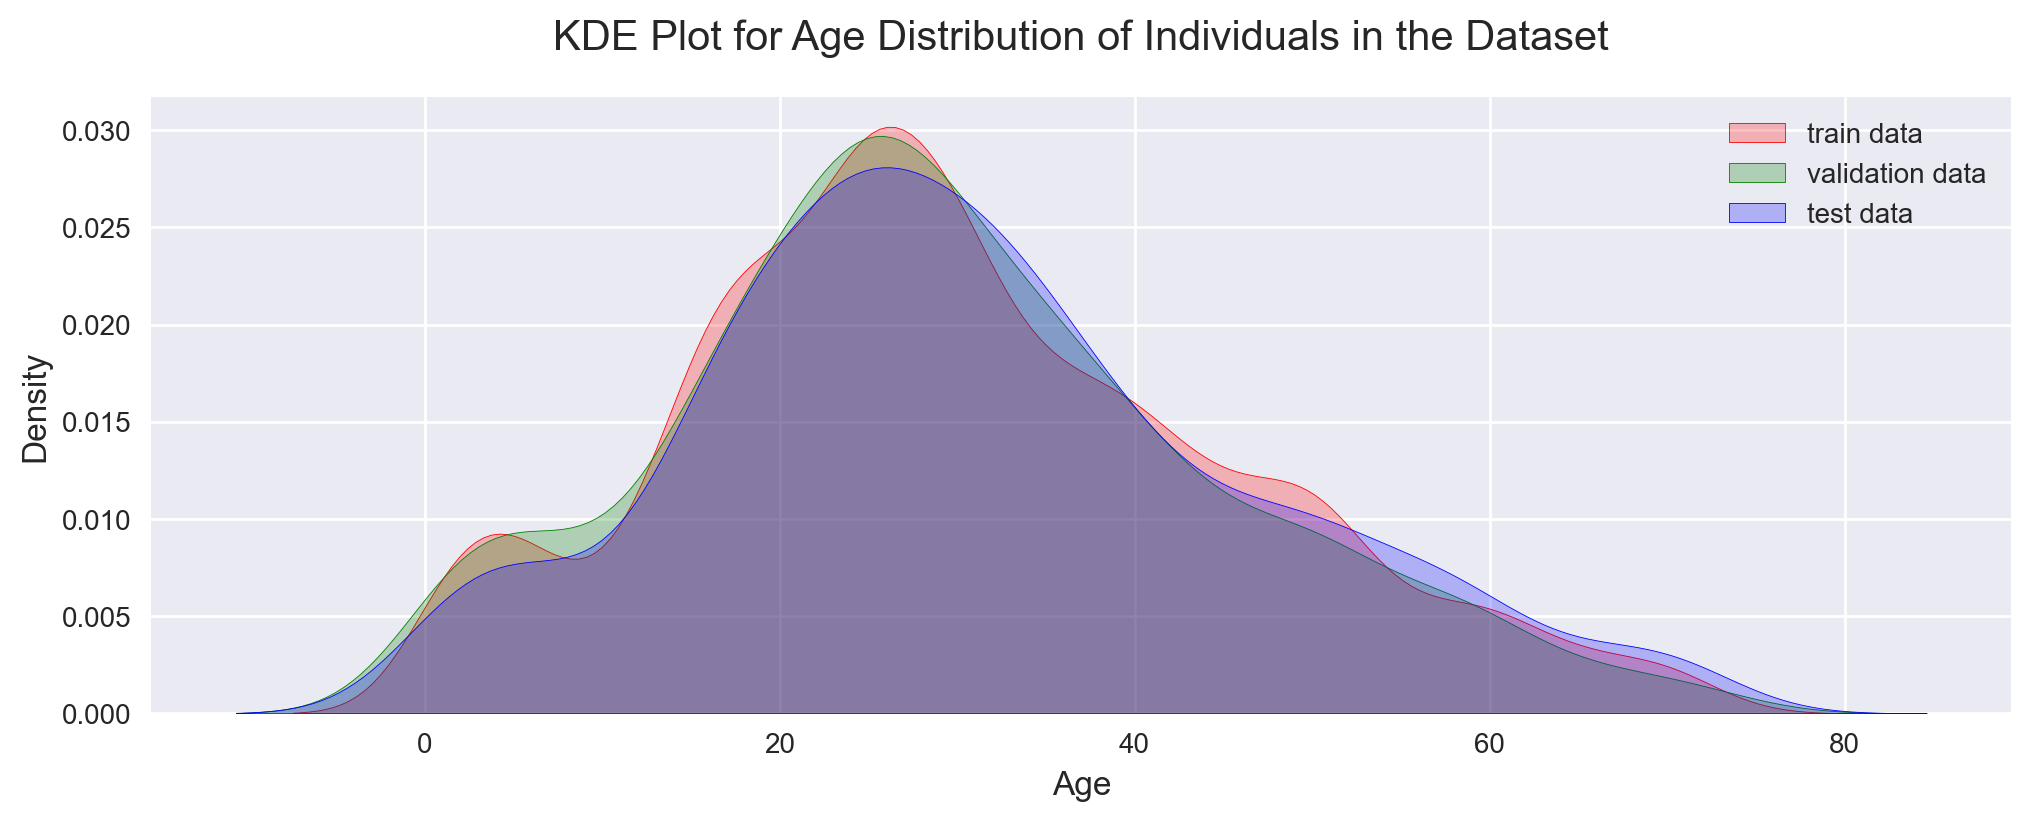

In [10]:
# perbandingan distribusi usia
fig, ax = plt.subplots(figsize=(12,4))
sns.kdeplot(train_data['real_age'], fill=True, color='red', label='train data', ax=ax)
sns.kdeplot(val_data['real_age'], fill=True, color='green', label='validation data', ax=ax)
sns.kdeplot(test_data['real_age'], fill=True, color='blue', label='test data', ax=ax)
plt.title("KDE Plot for Age Distribution of Individuals in the Dataset", size=15, y=1.05)
plt.xlabel('Age', size=12)
plt.ylabel('Density', size=12)
plt.legend()
plt.show()

Dari hasil di atas, ketiga dataset memiliki distribusi usia individu yang relatif sama.

Berikut di bawah ini kita akan membuat *function* yang dapat digunakan untuk memuat data dan melakukan pra-pemrosesan data pada gambar. Output dari *function* ini adalah *image generator* yang mengambil data dari direktori secara *batch* per *batch*. Untuk seluruh data, gambar akan di-*resize* agar memiliki ukuran 150x150 piksel serta melakukan normalisasi dengan melakukan *scaling* pada besaran 1/255. Adapun khusus untuk *training set*, gambar akan diaugmentasi terlebih dahulu.

In [11]:
# function untuk membuat image generator pada training set
def load_train(df, path):
    augmented_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True, vertical_flip=True)
    
    train_data_flow = augmented_datagen.flow_from_dataframe(dataframe=df,
                                                            directory=path,
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(150, 150),
                                                            class_mode='raw',
                                                            batch_size=32,
                                                            seed=101010)
    
    return train_data_flow

# function untuk membuat image generator pada validation dan test set
def load_test(df, path, shuffle=True):
    if shuffle:
        seed = 101010
    else:
        seed=None

    datagen = ImageDataGenerator(rescale=1/255)
    test_data_flow = datagen.flow_from_dataframe(dataframe=df,
                                                 directory=path,
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(150, 150),
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=shuffle,
                                                 seed=seed)
    return test_data_flow

## 2) Membangun dan Melatih Arsitektur Model

Basis struktur yang akan digunakan dalam membangun model *Convolutional Neural Networks* untuk proyek ini adalah **`ResNet50V2`**. Penggunaan model ResNet disebabkan model ini memiliki performa yang sangat baik karena memiliki teknik *skip-connection* yang dapat menangani permasalahan *vanishing gradient*. Adapun *initial weights* yang akan digunakan yaitu model **`ResNet50V2`** yang telah dilatih pada dataset **`ImageNet`**.

Model **`ResNet`** pada dasarnya merupakan model klasifikasi gambar, sehingga pada proyek ini kita akan memodifikasi *top-layers* agar sesuai dengan kebutuhan proyek regresi yang kita lakukan. Pada proyek ini, kita mengoptimasi 2 jenis arsitektur *top-layers* yang dilakukan pada script terpisah &mdash; pada direktori `./src/hyperparameter_tuning/` &mdash; yang antara lain:

<div style="text-align:left; font-weight:bold;">
Arsitektur 1: ResNet50V2 &rarr; Conv &rarr; Avg.Pooling &rarr; Flatten &rarr; 1 x Dense &rarr; Dense(1)

Arsitektur 2: ResNet50V2 &rarr; GlobalAvg.Pooling &rarr; 4 x Dense &rarr; Dense(1)
</div>

Melalui proses optimasi menggunakan Optuna, arsitektur yang dapat menghasilkan skor Val-MAE terendah pada pelatihan sebanyak 10 epoch adalah Arsitektur 2 dengan konfigurasi sebagai berikut.

<div style="text-align:center; font-weight:bold;">
Arsitektur 2: ResNet50V2 &rarr; GlobalAvg.Pooling &rarr; Dense(2<sup>7</sup>) &rarr; Dense(2<sup>4</sup>) &rarr; Dense(2<sup>4</sup>) &rarr; Dense(2<sup>3</sup>) &rarr; Dense(1)<br>
Arsitektur 2: ResNet50V2 &rarr; GlobalAvg.Pooling &rarr; Dense(128) &rarr; Dense(16) &rarr; Dense(16) &rarr; Dense(8) &rarr; Dense(1)
</div>

Arsitektur *top layers* tersebut menggunakan fungsi aktivasi ReLU agar menghasilkan output positif. Nilai regularisasi optimal, yaitu 0.0023 dan 0.0314 untuk regularisasi L1 (*lasso regression*) dan regularisasi L2 (*ridge regression*) secara berurutan. Adapun besaran nilai *learning rate* yang digunakan, yaitu sebesar 0.0001.

Berikut merupakan *summary* hasil optimasi menggunakan Optuna pada **Arsitektur 2**.


In [12]:
# menampilkan hasil optimasi menggunakan optuna
ars2_path = './hyperparameter_tuning/arsitektur_2.log'
with open(ars2_path, 'r') as f:
    result = list(filter(lambda x: x.startswith('Trial'), f.readlines()))
    best_param = ast.literal_eval(re.findall("{[\w':,. ]+}", result[-1])[0])

print(''.join(result))

Trial 0 finished with best value: 8.425087928771973 and parameters: {'exp_1': 5, 'exp_2': 5, 'exp_3': 5, 'exp_4': 4, 'l1_constant': 0.06901518316661631, 'l2_constant': 0.053338322449125765}. 
Trial 1 finished with best value: 8.225018501281738 and parameters: {'exp_1': 8, 'exp_2': 4, 'exp_3': 4, 'exp_4': 4, 'l1_constant': 0.08375300486726667, 'l2_constant': 0.03492378242558599}. 
Trial 2 finished with best value: 7.182906627655029 and parameters: {'exp_1': 6, 'exp_2': 5, 'exp_3': 4, 'exp_4': 3, 'l1_constant': 0.004805341361593249, 'l2_constant': 0.06993468790280583}. 
Trial 14 finished with best value: 7.098989963531494 and parameters: {'exp_1': 7, 'exp_2': 4, 'exp_3': 4, 'exp_4': 3, 'l1_constant': 0.0022583629353694805, 'l2_constant': 0.031395551492311005}. 



In [13]:
# menambahkan regularisasi pada ResNet50V2
def add_regularization(model, regularizer):
    # menambahkan informasi regularizer pada layer Dense atau Conv2D pada config file
    for layer in model.layers:
        if isinstance(layer, (Conv2D, Dense)):
            layer.kernel_regularizer = regularizer
    
    # Saat kita mengubah atribut layer, perubahan hanya terjadi pada file konfigurasi model
    model_config = model.to_json()

    # Simpan bobot sebelum memuat ulang model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # memuat model dari config file
    model = tf.keras.models.model_from_json(model_config)

    # memuat nilai bobot yang sudah disimpan
    model.load_weights(tmp_weights_path, by_name=True)

    return model

# arsitektur model
def create_model(input_shape=(150,150,3)):
    # ResNet50V2 backbone
    backbone = ResNet50V2(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)
    
    # best hyperparameter
    l1_constant = best_param['l1_constant']
    l2_constant = best_param['l2_constant']
    neuron_1 = 2**best_param['exp_1']
    neuron_2 = 2**best_param['exp_2']
    neuron_3 = 2**best_param['exp_3']
    neuron_4 = 2**best_param['exp_4']

    # mengatur regularisasi pada backbone
    backbone = add_regularization(backbone, l1_l2(l1=l1_constant, l2=l2_constant))

    # add new top layers
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=neuron_1, activation='relu', kernel_regularizer=l1_l2(l1=l1_constant, l2=l2_constant)))
    model.add(Dense(units=neuron_2, activation='relu', kernel_regularizer=l1_l2(l1=l1_constant, l2=l2_constant)))
    model.add(Dense(units=neuron_3, activation='relu', kernel_regularizer=l1_l2(l1=l1_constant, l2=l2_constant)))
    model.add(Dense(units=neuron_4, activation='relu', kernel_regularizer=l1_l2(l1=l1_constant, l2=l2_constant)))
    model.add(Dense(1, activation='relu', kernel_regularizer=l1_l2(l1=l1_constant, l2=l2_constant)))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    return model

Berikut di bawah ini merupakan *function* untuk melakukan pelatihan model. Pelatihan akan dilakukan sebanyak 50 epoch, dimana model dengan skor `val_mae` terbaik akan disimpan pada *checkpoint*.

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=50, steps_per_epoch=None, validation_steps=None):
    history = model.fit(train_data,
                        validation_data=test_data,
                        batch_size=batch_size,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        verbose=2,
                        callbacks=[
                            keras.callbacks.ModelCheckpoint(filepath='../assets/best_checkpoint.model.keras',
                                                            monitor='val_mae',
                                                            mode='min',
                                                            save_best_only=True),
                            keras.callbacks.CSVLogger(filename='../assets/training_result.log'),
                            # keras.callbacks.TensorBoard(log_dir='./tb_logs/')
                        ]
              )
    return history

Berikut di bawah ini kita akan melakukan pelatihan model yang sudah dibangun sebelumnya.

In [15]:
%%time
# mengatur randomness model keras
tf.keras.utils.set_random_seed(101010)
tf.config.experimental.enable_op_determinism()

print(f"Is GPU available: {tf.test.is_gpu_available()}\n")

train_gen = load_train(train_data, '../datasets/faces/final_files/')
val_gen = load_test(val_data, '../datasets/faces/final_files/')
model = create_model()
print(model.summary())
history = train_model(model, train_gen, val_gen, epochs=50)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True

Found 5202 validated image filenames.
Found 1115 validated image filenames.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
       

Berikut merupakan kurva *loss* dan MAE hasil pelatihan model untuk setiap epoch.

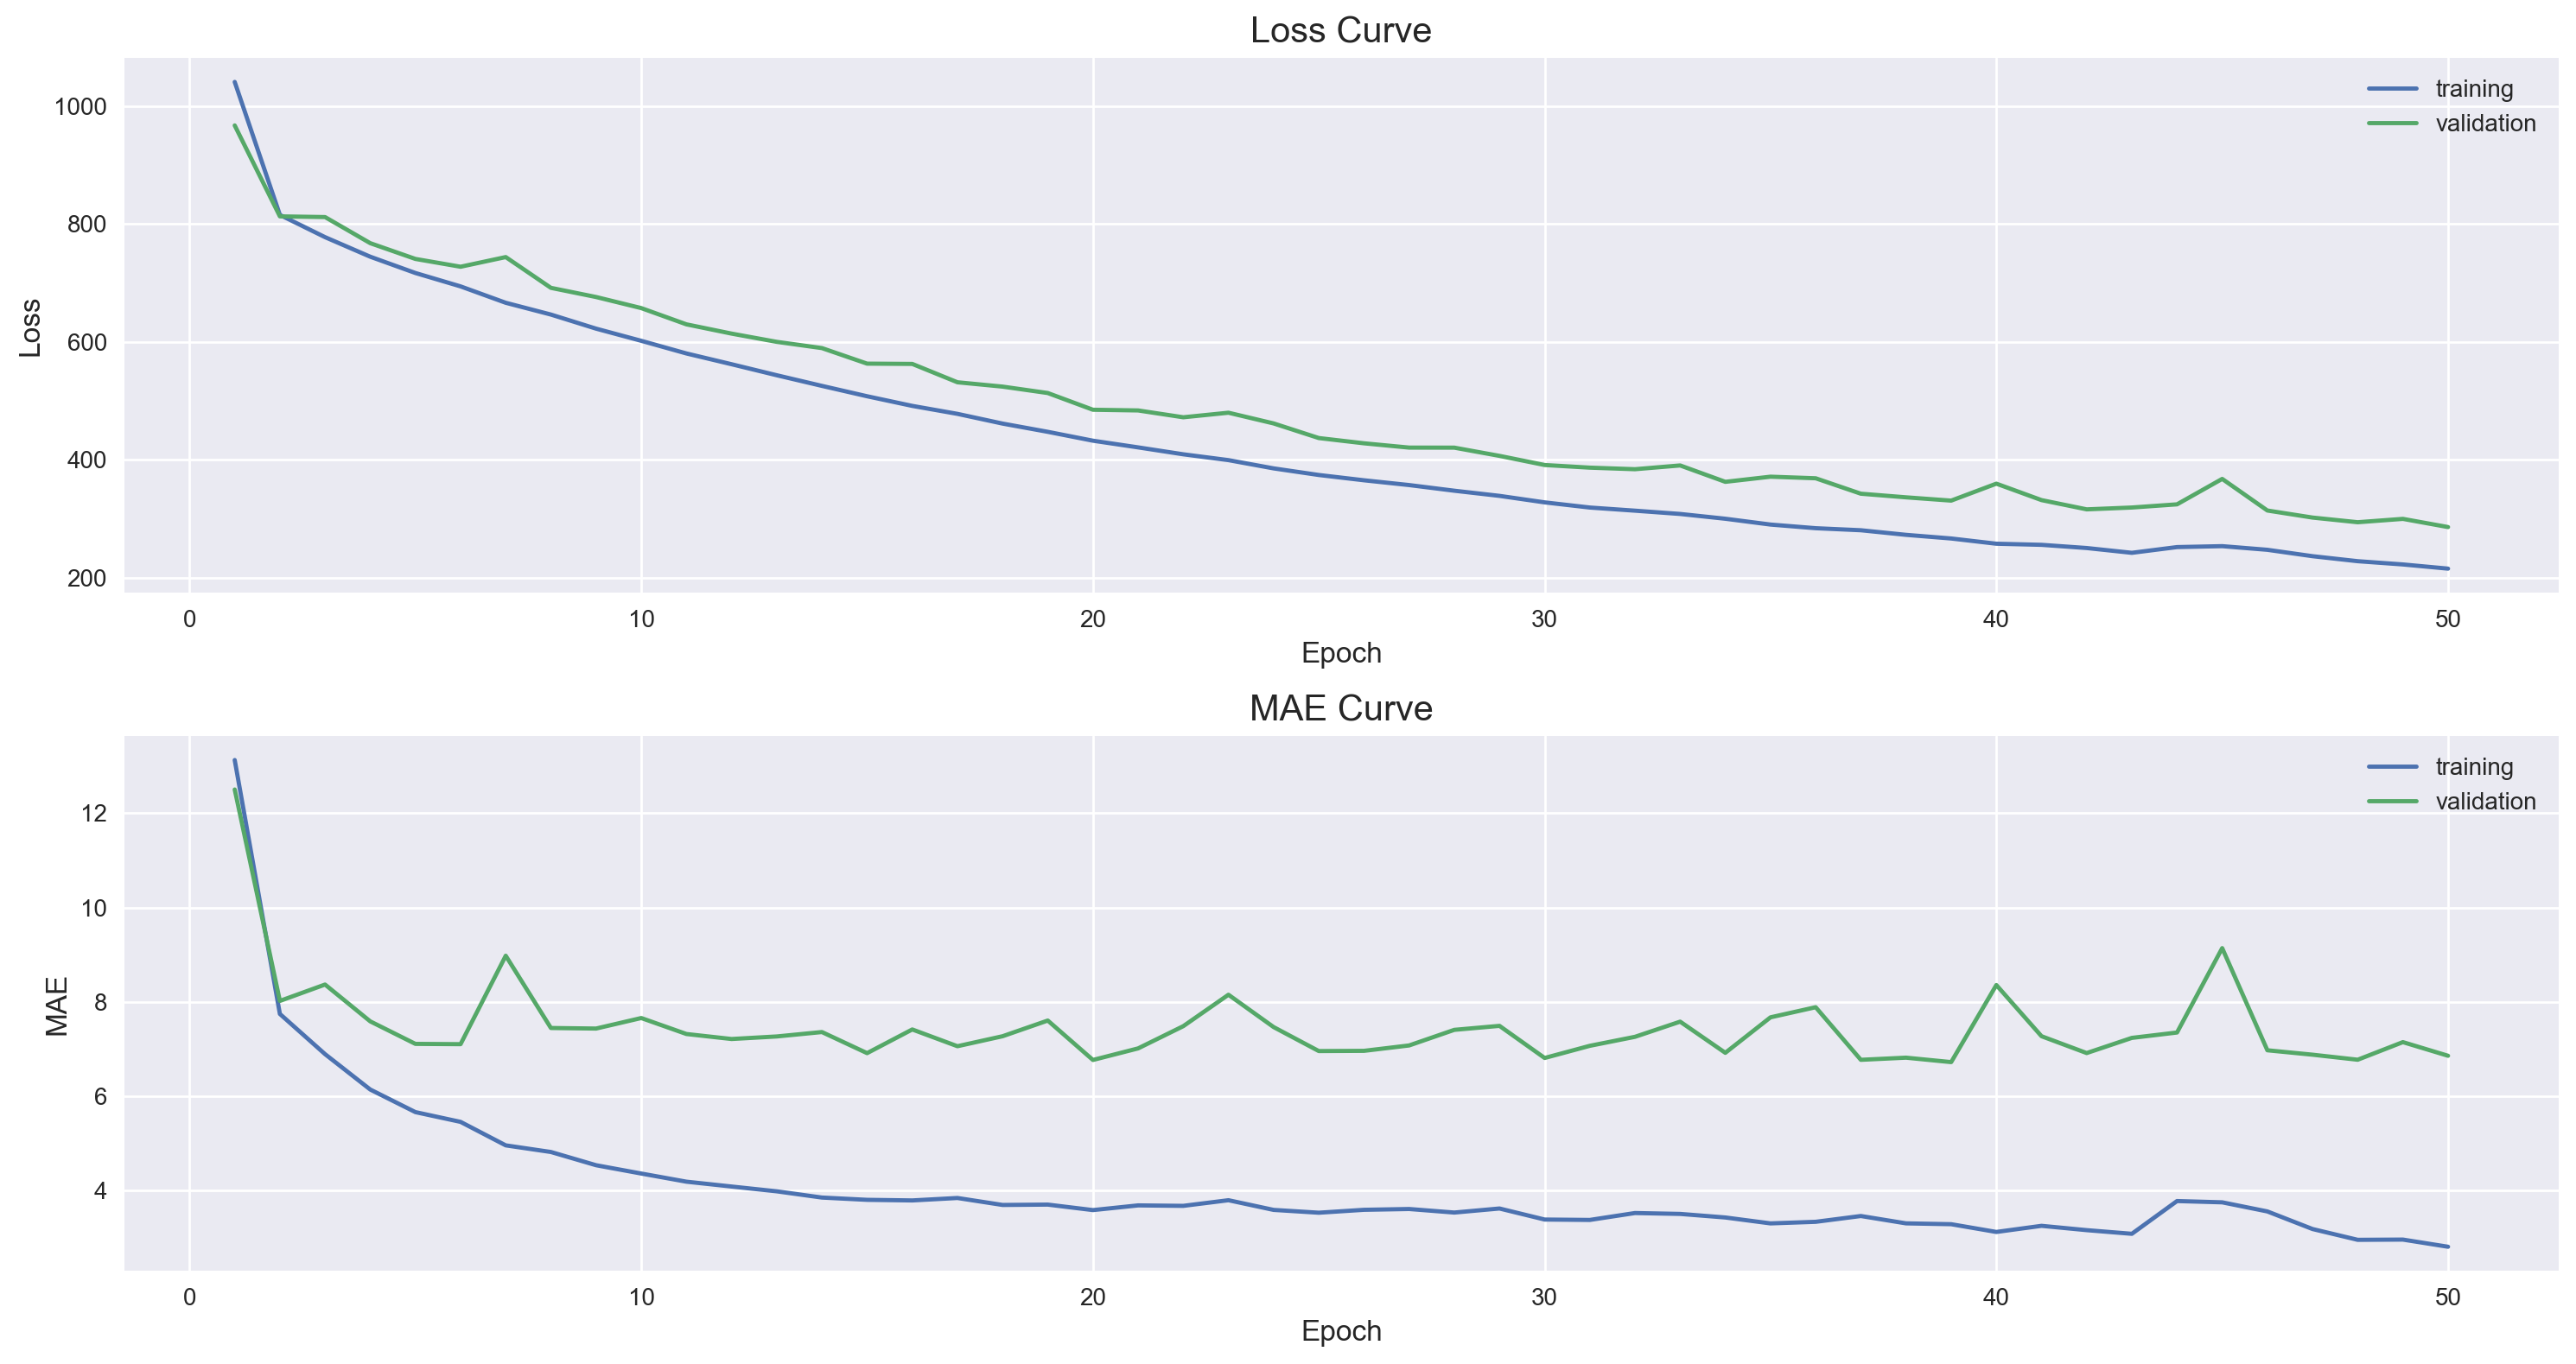

In [16]:
# kurva loss dan MAE
train_result = pd.DataFrame(history.history)
train_result['epoch'] = range(1, train_result.shape[0]+1)

fig, ax = plt.subplots(nrows=2, figsize=(15, 8))
sns.lineplot(data=train_result, x='epoch', y='loss', ax=ax[0], label='training')
sns.lineplot(data=train_result, x='epoch', y='val_loss', ax=ax[0], label='validation')
sns.lineplot(data=train_result, x='epoch', y='mae', ax=ax[1], label='training')
sns.lineplot(data=train_result, x='epoch', y='val_mae', ax=ax[1], label='validation')
ax[0].set_title("Loss Curve", size=15)
ax[1].set_title("MAE Curve", size=15)
ax[0].set_xlabel("Epoch", size=12)
ax[1].set_xlabel("Epoch", size=12)
ax[0].set_ylabel("Loss", size=12)
ax[1].set_ylabel("MAE", size=12)
plt.tight_layout()

Berikut merupakan hasil evaluasi model terbaik pada *validation set*.

In [17]:
# evaluasi model terbaik
best_model = keras.models.load_model('../assets/best_checkpoint.model.keras')

print(f"{' Evaluasi Model Terbaik Pada Validation Set ':-^90}\n")
best_model.evaluate(val_gen)
print(f"\n{'':-^90}")

----------------------- Evaluasi Model Terbaik Pada Validation Set -----------------------

35/35 [==============================] - 7s 140ms/step - loss: 330.6503 - mae: 6.7181

------------------------------------------------------------------------------------------


<h3 style="font-weight:bold; font-family:Trebuchet MS">Findings & Insights</h3>
<div style="margin-left:1%; margin-top:1%; width:97%; text-align:justify">

* Dari kurva di atas terlihat bahwa model tidak terlalu *overfitting*. Hal tersebut terlihat dari *slope* trend pada kurva validasi yang hampir sama dengan kurva *training*.
* Skor MAE model ketika memprediksi *validation set* adalah 6,7181 tahun dimana angka ini telah memenuhi kebutuhan proyek, yakni MAE &le; 8 tahun.

</div>

## 3) Evaluasi Model

Pada tahap ini kita akan menguji model terbaik yang telah diperoleh saat pelatihan pada *testing dataset*.

In [18]:
# evaluasi model pada testing set
test_gen = load_test(test_data, '../datasets/faces/final_files/', shuffle=False)

print(f"{' Evaluasi Model Terbaik Pada Testing Set ':-^90}\n")
best_model.evaluate(test_gen)
print(f"\n{'':-^90}")

Found 1115 validated image filenames.
------------------------ Evaluasi Model Terbaik Pada Testing Set -------------------------

35/35 [==============================] - 5s 139ms/step - loss: 325.5737 - mae: 6.8516

------------------------------------------------------------------------------------------


<h3 style="font-weight:bold; font-family:Trebuchet MS">Findings & Insights</h3>
<div style="margin-left:1%; margin-top:1%; width:97%; text-align:justify">

* Skor MAE model ketika memprediksi *testing set* adalah 6,8516 tahun dimana angka ini telah memenuhi kebutuhan proyek, yakni MAE &le; 8 tahun.
* Dibandingkan hasil evaluasi pada *validation set*, hasil evaluasi pada *testing set* tidak terpaut jauh, hanya selisih 0,13 tahun. 

</div>

Berikut di bawah ini, kita akan menampilkan *scatter plot* yang menunjukkan usia aktual dan usia yang diprediksi oleh model. Usia aktual berada pada sumbu-x, sedangkan usia prediksi akan berada pada sumbu-y. Pada grafik di bawah, akan ditampilkan pula garis prediksi untuk MAE = 0 tahun (garis putus-putus) dan area untuk MAE &le; 8 tahun.

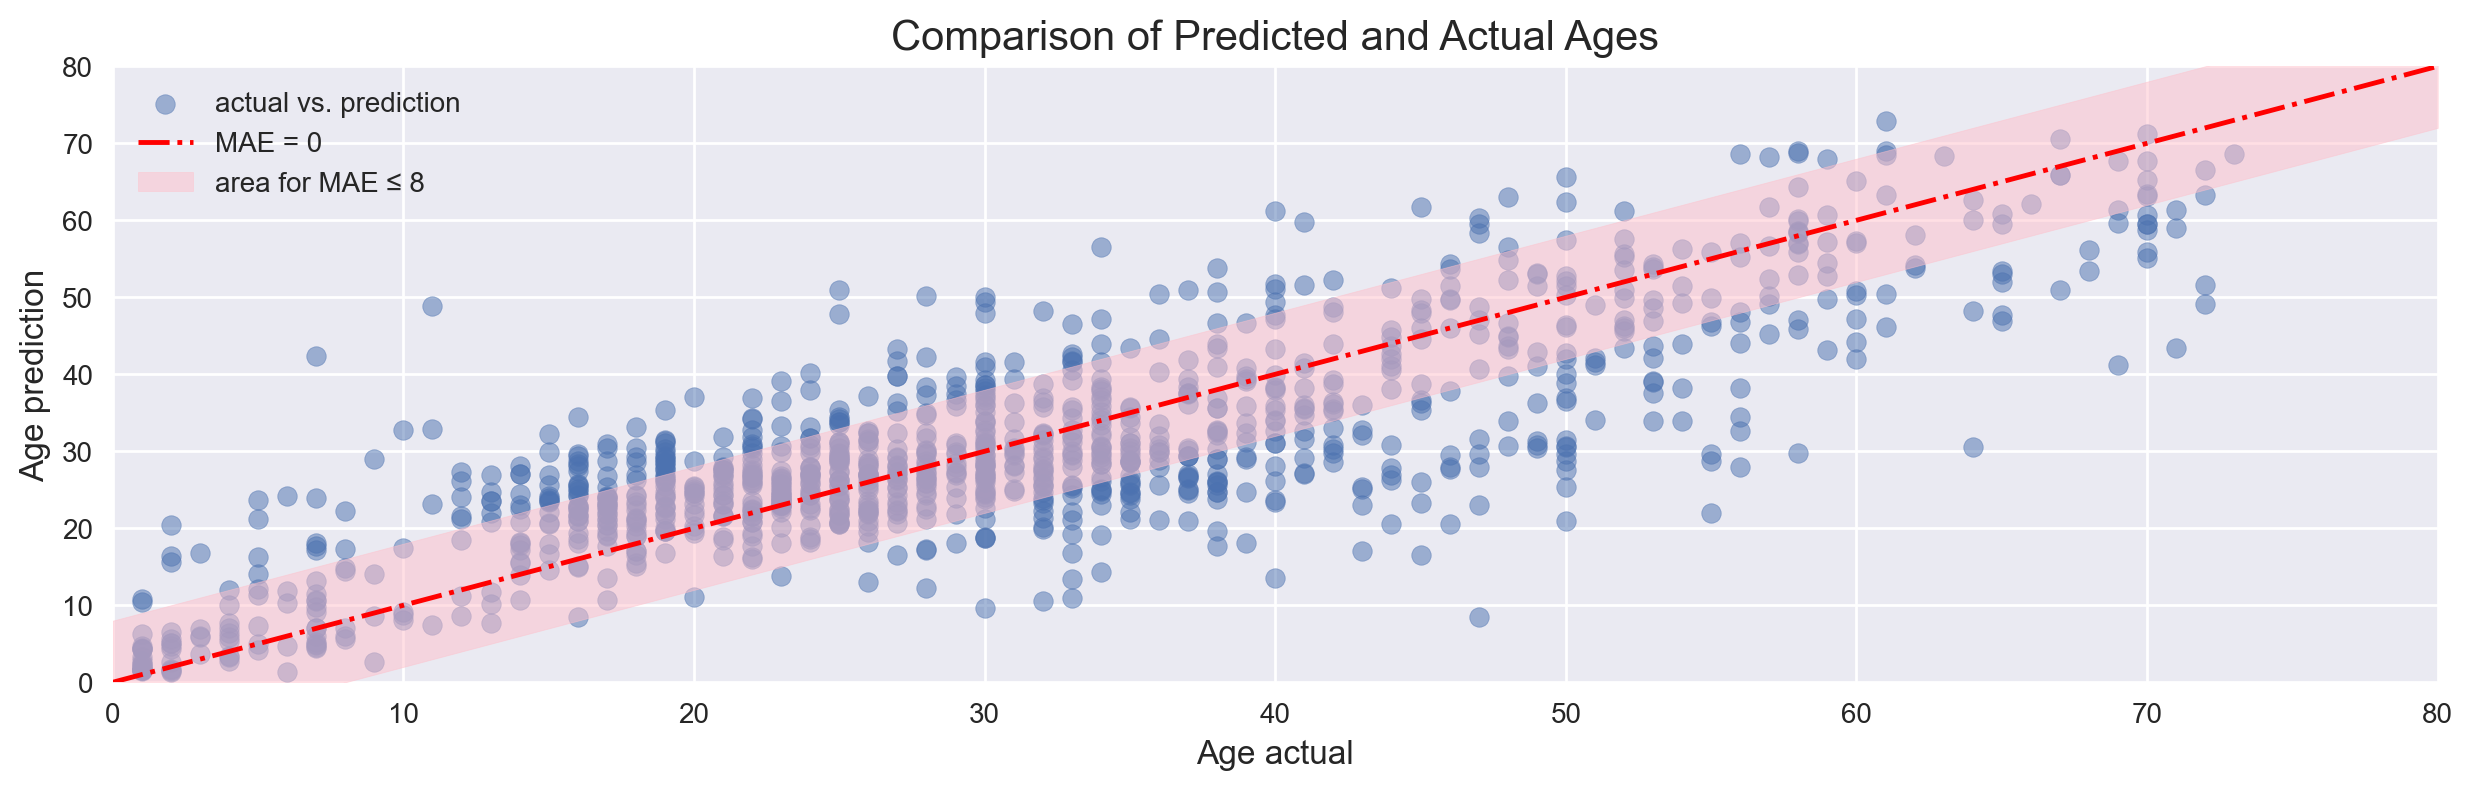

In [19]:
# membuat plot perbandingan data aktual dan prediksi
test_predict = best_model.predict(test_gen, verbose=0).reshape(-1)
test_actual = test_data['real_age'].values

plt.figure(figsize=(15,4))
plt.scatter(test_actual, test_predict, label='actual vs. prediction', alpha=0.5)

# garis MAE = 0
plt.plot(np.arange(0, 81, 1), np.arange(0, 81, 1), linestyle='dashdot', color='red', label='MAE = 0')

# Area MAE <= 8
plt.fill_between(np.arange(0, 81, 1), np.arange(0, 81, 1)+8, np.arange(0, 81, 1)-8, color='pink', alpha=0.5, 
                 label='area for MAE \u2264 8')

plt.title("Comparison of Predicted and Actual Ages", size=15)
plt.ylabel("Age prediction", size=12)
plt.xlabel("Age actual", size=12)
plt.legend()
plt.xlim((0, 80))
plt.ylim((0, 80))
plt.show()

<h3 style="font-weight:bold; font-family:Trebuchet MS">Findings & Insights</h3>
<div style="margin-left:1%; margin-top:1%; width:97%; text-align:justify">

* Area berwarna merah merupakan area kualitas model yang diinginkan pada proyek ini, yaitu MAE &le; 8. Semakin banyak data di dalam area tersebut, maka akan semakin baik model yang kita miliki.
* Apabila membandingkan data di dalam dan di luar area merah untuk setiap umur, dapat terlihat dengan jelas kelompok umur di atas 40 tahun mengalami prediksi usia di bawah usia sebenarnya. Hal ini menunjukkan bahwa model memiliki performa yang kurang baik ketika memperkirakan usia orang di atas 40 tahun.
* Mayoritas prediksi model untuk orang-orang berusia kurang dari 40 tahun menunjukkan performa yang baik, karena lebih banyak data di dalam area merah dibandingkan di luar.

</div>

# **F. Kesimpulan**

Proses pembuatan model prediktif untuk memperkirakan usia seseorang berdasarkan photo sudah usai. Berikut merupakan kesimpulan dan sejumlah temuan penting selama proses pengerjaan proyek.

<h3 style="font-weight:bold; font-family:Trebuchet MS">Hasil Analisa Data</h3>
<div style="margin-left:2%; width:95%; text-align:justify">

* Dataset pada proyek ini cukup bervariasi, baik secara usia, orientasi dan bentuk photo.
* Ukuran gambar pada dataset berkisar pada 47 piksel hingga 4466 piksel, sehingga pada proyek ini data gambar perlu diseragamkan ukurannya.
* Distribusi usia orang di dalam dataset memiliki median pada usia 29 tahun dan terdistribusi *right-skew*. Terdapat data *sub-mode* untuk usia pada rentang 1-5 tahun.
* Berdasarkan metode IQR, data yang tergolong bukan *outliers* adalah data dengan usia antara 0- 72,5 tahun.

</div>

<h3 style="font-weight:bold; font-family:Trebuchet MS">Hasil Membangun Model</h3>
<div style="margin-left:2%; width:95%; text-align:justify">

* Dataset pada proyek ini dibagi menjadi 3 bagian dengan proporsi 70:15:15 untuk *training set*, *validation set* dan *testing set* secara berurutan. Distribusi usia untuk ketiga dataset setelah dibagi menjadi tiga sudah dipastikan memiliki distribusi yang serupa.
* Data gambar memiliki ukuran yang bervariasi, sehingga gambar diolah agar memiliki ukuran yang seragam. Pada proyek ini gambar diatur agar memiliki ukuran sebesar 150x150 piksel. Untuk kecerahan gambar, data gambar dinormalisasi agar semula memiliki nilai pada rentang 0-255, menjadi bernilai 0-1.
* Untuk kebutuhan pelatihan, *training set* dilakukan augmentasi. Adapun dua dataset lainnya tidak diberikan augmentasi.
* Model prediktif yang dibangun berbasis **ResNet50V2**. Model **ResNet50V2** dimodifikasi area *top-layers* agar sesuai dengan kebutuhan proyek regresi yang dilakukan. berikut merupakan modifikasi arsitektur yang paling optimal.
<div style="text-align:center; font-weight:bold;">
Arsitektur 2: ResNet50V2 &rarr; GlobalAvg.Pooling &rarr; Dense(128) &rarr; Dense(16) &rarr; Dense(16) &rarr; Dense(8) &rarr; Dense(1)
</div>

* Arsitektur *top-layers* menggunakan fungsi aktivasi ReLU agar menghasilkan output positif. Regularisasi L1 (*lasso regression*) dan L2 (*ridge regression*) dengan nilai konstanta regularisasi sebesar 0,0023 dan 0,0314 diterapkan pada arsitektur dasar (ResNet50V2) dan arsitektur tambahan (*top layers*).
* Dari hasil evaluasi, model memiliki skor MAE sebesar 6,7181 pada *validation set* dan 6,8516 pada *testing set*. Oleh karena itu, proyek berhasil dilaksanakan karena model memiliki MAE &le; 8.
* Performa model yang dibangun pada proyek ini memiliki kemampuan prediksi yang baik untuk kelompok usia di bawah 40 tahun. Akan tetapi untuk kelompok usia di atas 40 tahun, model akan cenderung melakukan prediksi di bawah usia sebenarnya.


</div>